(leakage)=
# Spectral leakage and windowing

In [1]:
%run ../setup.ipynb

In this section, we'll take a more in-depth look at how the DFT responds to non-analysis frequencies, and how we might counteract these effects.

In an earlier section, we've seen that waves at non-analysis frequencies can produce sharp discontinuities at the boundaries of the signal ({numref}`circ_shift`).
If we were to listen to a signal like this on a repeating loop, these discontinuities would become audible as *clicks* or *pops*, not dissimilar to the sound of an impulse.

To illustrate the point, here we'll construct a pure sinusoid at $f = 111$, with $f_s = 1000$, and sample for 1/4 second ($N= f_s/4 = 250$).
This produces the following wave:

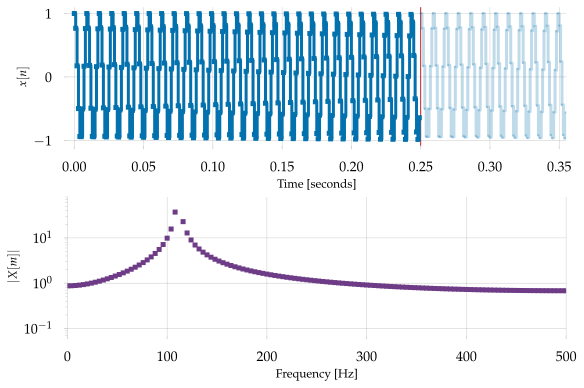

In [2]:
fig, (ax, axf) = plt.subplots(nrows=2, figsize=figaspect(0.66))

fs = 1000
N = fs//4
f = 111

t = np.arange(N) / fs
x = np.cos(2 * np.pi * f * t)


ax.step(t, x, marker='s', where='post')
ax.step(t + N / fs, x,  marker='.', where='post',  alpha=0.25, color=colors[0])
ax.axvline(N / fs, zorder=-50, color=colors[1], linewidth=1)
ax.set(xlabel='Time [seconds]')
ax.set(xlim=[-0.005, 0.355],  ylabel=r'$x[n]$')

X = np.fft.rfft(x)
freqs = np.abs(np.fft.fftfreq(N, 1./fs))[:1+N//2]

axf.semilogy(freqs, np.abs(X), linestyle='', marker='s', color=colors[4])
axf.set(xlabel='Frequency [Hz]', ylabel=r'$|X[m]|$', ylim=[7e-2, 8e1])
glue('f110', fig, display=False)

```{glue:figure} f110
*Top*: A wave at frequency $f=111$, with sampling rate $f_s=1000$ and duration of 1/4 second ($N=f_s/4$).
$f=111$ is not an integer multiple of $f_s/N = 4$, so it is not an analysis frequency.
Note the large gap between samples when the signal repeats at $t=0.25$.
*Bottom*: The DFT spectrum of $x[n]$, displayed on a logarithmic scale.
```

Looping this sample 8 times produces a signal of duration $N= 2\cdot f_s = 2$ seconds, with audible glitches every 1/4 second:


In [3]:
# FIXME: build a new example that works in all browsers
from IPython.display import Audio
import scipy.signal

fs = 1000
N = fs//4
f = 111

t = np.arange(N) / fs
x = np.tile(np.cos(2 * np.pi * f * t), 8)

y = scipy.signal.resample(x, 8 * len(x))
Audio(data=y, rate=8*fs)

To understand this behavior in the frequency domain, it can be helpful to think about the DFT of a unit impulse or delay signal (see {numref}`dft-impulse`).
Impulses---and more generally, sharp discontinuities---are not easy to express with smoothly varying sinusoids, and this is why it takes the entire set of analysis frequencies to represent a delay signal (all $X[m]$ are non-zero in {numref}`impulse-dft`).

A similar thing happens to non-analysis frequencies: to explain the discontinuity at the boundary of the signal, the DFT uses the entire frequency spectrum, again producing non-zero DFT magnitudes $|X[m]|$ across the frequency spectrum.  This phenomenon is called **spectral leakage**: the energy associated with our non-analysis frequency $f$ has "leaked" over the entire spectrum.

The bad news is that spectral leakage cannot be avoided in general.  The energy in a signal associated with each frequency has to go somewhere in the DFT, and if the frequency does not correspond to one of our analysis frequencies, then it will spread out.

The good news is that we can, to some extent, control leakage to direct the leaked energy in various ways.
This is accomplished by a technique called **windowing**.

(windowing)=
## Windowing

The idea of windowing a signal is to force continuity at the boundaries, prior to performing the DFT.
The simplest way to achieve this is by multiplying the signal $x[n]$ by another signal $w[n]$ of the same duration, such that $w[0] \approx w[N-1] \approx 0$, resulting in the *windowed DFT* $\hat{X}$:
```{math}
\hat{X} \leftarrow \text{DFT}(x[n] \cdot w[n])
```

For example, {numref}`windowing-example` illustrates this using what's known as a *Hann* window.

`````{margin} 
````{admonition} Definition: Hann window
A (discrete) *Hann window* of $N$ samples is defined by the following equation:

```{math}
w[n] = \sin^2 \left( \frac{\pi n}{N} \right)
```
for $n = 0, 1, 2, \dots, N-1$.
````
`````

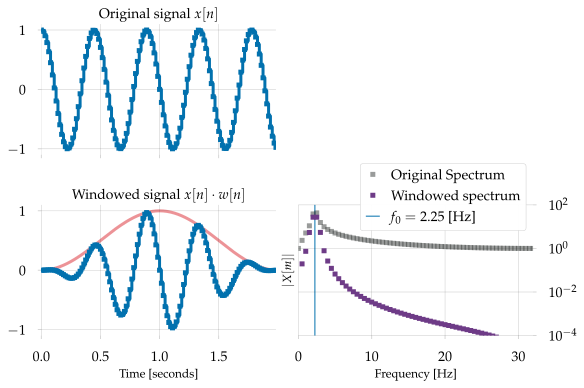

In [11]:
from matplotlib import gridspec

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figaspect(0.66), sharey='col', sharex='col')

fs = 64
N = 2 * fs

f0 = 4.5 * fs / N

t = np.arange(N) / fs
x = np.cos(2 * np.pi * f0 * t)

w = scipy.signal.get_window('hann', len(x))

freqs = np.abs(np.fft.fftfreq(N, 1./fs)[:1 + N//2])

axes[0, 0].step(t, x,  marker='s', where='post')
axes[0, 0].label_outer()
axes[0, 1].remove()

axes[1, 0].step(t, x * w, marker='s', where='post')
axes[1, 0].plot(t, w, color=colors[1], alpha=0.5, zorder=-1)
axes[1, 0].label_outer()

axes[1, 1].semilogy(freqs, np.abs(np.fft.rfft(x)), linestyle='', marker='s', color=colors[3], alpha=0.5, label='Original Spectrum')
axes[1, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w)), linestyle='', marker='s', color=colors[4], label='Windowed spectrum')
axes[1, 1].set(ylim=[-1, 100])
axes[0, 0].set(title=r'Original signal $x[n]$')
axes[1, 0].set(title=r'Windowed signal $x[n] \cdot w[n]$')
axes[1, 1].axvline(f0, color=colors[0], linewidth=1, zorder=-1, label=f'$f_0={f0}$ [Hz]')

axes[1, 1].legend(loc='lower right', bbox_to_anchor=(1, 0.75))
axes[1, 0].set(xlabel='Time [seconds]')
axes[1, 1].set(xlabel='Frequency [Hz]')

axes[1, 1].set(ylabel=r'$|X[m]|$')
axes[1, 1].set(ylim=[1e-4, 100])
axes[1, 1].yaxis.tick_right()

glue('windowing', fig, display=False)

```{glue:figure} windowing
---
name: windowing-example
---

A sinusoid at a non-analysis frequency (*upper-left*, $f=2.25$, $N=128$, $f_s=64$) produces spectral energy at all frequencies in the DFT (*original spectrum*, bottom-right).
Multiplying the sinusoid by a window function (*bottom-left*) tapers the signal values to 0 at the beginning and end, and reduces spectral leakage in the DFT spectrum (*windowed spectrum*, bottom-right).
```

Taking the DFT after windowing the signal significantly reduces the magnitude of components $X[m]$ when $m$ is far from the true frequency of the input signal, but retains energy for $m$ close to the true frequency.

If we loop the windowed signal, rather than the original signal, we'll see that the boundary discontinuities have vanished.

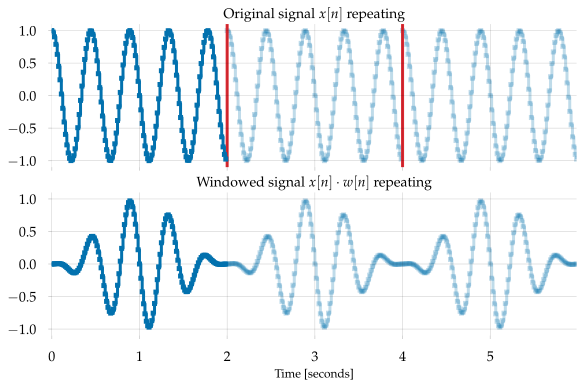

In [12]:
from matplotlib import gridspec

fig, axes = plt.subplots(nrows=2, figsize=figaspect(0.66), sharey='col', sharex='col')

fs = 64
N = 2 * fs

f0 = 4.5 * fs / N

t = np.arange(N) / fs
x = np.cos(2 * np.pi * f0 * t)

w = scipy.signal.get_window('hann', len(x))

freqs = np.abs(np.fft.fftfreq(N, 1./fs)[:1 + N//2])

xw = x * w

trep = np.arange(N, 3 * N) / fs

xrep = np.tile(x, 2)
xwrep = np.tile(xw, 2)

axes[0].step(t, x, marker='s', where='post')
axes[0].step(trep, xrep,  marker='s', where='post', color=colors[0], alpha=0.25, zorder=-1)
axes[0].label_outer()
axes[0].axvline(2, color=colors[1],  zorder=-1)
axes[0].axvline(4, color=colors[1],  zorder=-1)
axes[1].step(t, xw, where='post', marker='s')
axes[1].step(trep, xwrep,  marker='s', where='post', color=colors[0], alpha=0.25, zorder=-1)
axes[1].label_outer()

axes[0].set(title=r'Original signal $x[n]$ repeating')
axes[1].set(title=r'Windowed signal $x[n] \cdot w[n]$ repeating')

axes[1].set(xlabel='Time [seconds]')

glue('window-repeating', fig, display=False)

```{glue:figure} window-repeating
---
name: window-repeating
---

*Top*: repeating a sinusoid at a non-analysis frequency produces discontinuities when the signal repeats ($t=2, 4$).
*Bottom*: windowing the sinusoid prior to repetition eliminates discontinuities, but introduces low-frequency modulation.
```

As shown in {numref}`window-repeating`, the elimination of discontinuities does not come for free: we have also introduced a low-frequency amplitude modulation to the looped signal.

This effect is certainly audible.
If we apply windowing to the previous example ($f=111$ Hz sampled at $f_s=1000$), and listen to the repeating signal as before, each loop of the signal now has a *pulse* due to the window.

In [14]:
from IPython.display import Audio
fs = 1000
N = fs//4
f = 111

t = np.arange(N) / fs
w = scipy.signal.get_window('hann', N, fftbins=False)
x = np.cos(2 * np.pi * f * t)
x = np.tile(x * w, 8)
y = scipy.signal.resample(x, 8 * len(x))
Audio(data=y, rate=8*fs)

In practice, one would not typically use windowing in this fashion, but it is helpful to listen to the looped signal to get a better intuition for what the signal looks like to the DFT.
In this example, we have traded off transient discontinuities for a smoothly varying pulse, which can be more easily modeled by sinusoids.

## Choosing a window

In our first example, we used a Hann window, which is essentially a carefully tuned cosine wave, but there are many, many, many other options!
Most window functions have non-linear curves, and often end up resembling a "bell curve".

We won't go into the details of how each of these window functions are defined, but {numref}`window-examples` demonstrates a handful of commonly used windows.

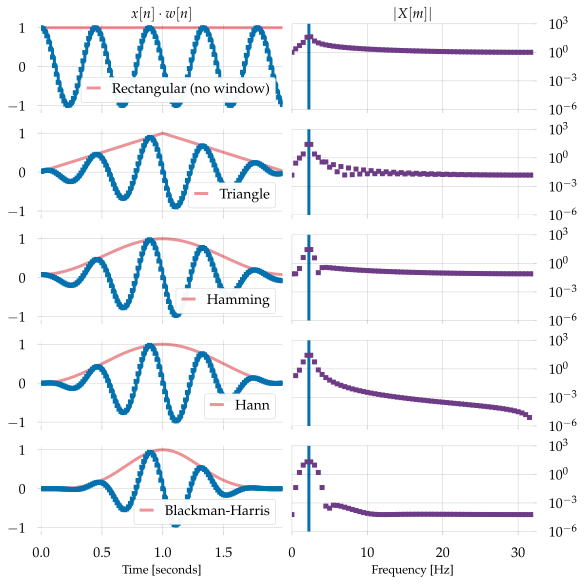

In [15]:
from matplotlib import gridspec

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=figaspect(1), sharey='col', sharex='col')

fs = 64
N = 2 * fs

f0 = 4.5 * fs / N

t = np.arange(N) / fs
x = np.cos(2 * np.pi * f0 * t)

w0 = scipy.signal.get_window('rect', len(x))
w1 = scipy.signal.get_window('triang', len(x))
w2 = scipy.signal.get_window('hamming', len(x))
w3 = scipy.signal.get_window('hann', len(x))
w4 = scipy.signal.get_window('blackmanharris', len(x))

freqs = np.abs(np.fft.fftfreq(N, 1./fs)[:1 + N//2])

for n in range(len(axes)):
    axes[n, 1].yaxis.tick_right()
    
axes[0, 0].step(t, x * w0, marker='s', where='post')
axes[0, 0].plot(t, w0, color=colors[1],  alpha=0.5, zorder=-1, label='Rectangular (no window)')
axes[0, 0].legend(loc='lower right')
axes[0, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w0)), linestyle='', marker='s',  color=colors[4])
axes[0, 1].axvline(f0, zorder=-1, color=colors[0])
axes[0, 0].label_outer()
#axes[0, 1].label_outer()

axes[1, 0].step(t, x * w1,   marker='s',  where='post')
axes[1, 0].plot(t, w1, color=colors[1],  alpha=0.5, zorder=-1, label='Triangle')
axes[1, 0].legend(loc='lower right')
axes[1, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w1)), linestyle='', marker='s', color=colors[4])
axes[1, 1].axvline(f0, zorder=-1, color=colors[0])
axes[1, 0].label_outer()
#axes[1, 1].label_outer()

axes[2, 0].step(t, x * w2,  marker='s', where='post')
axes[2, 0].plot(t, w2, color=colors[1],  alpha=0.5, zorder=-1, label='Hamming')
axes[2, 0].legend(loc='lower right')
axes[2, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w2)), linestyle='', marker='s',  color=colors[4])
axes[2, 1].axvline(f0, zorder=-1,  color=colors[0])
axes[2, 0].label_outer()
#axes[2, 1].label_outer()

axes[3, 0].step(t, x * w3,  marker='s', where='post')
axes[3, 0].plot(t, w3, color=colors[1], alpha=0.5, zorder=-1, label='Hann')
axes[3, 0].legend(loc='lower right')
axes[3, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w3)), linestyle='', marker='s',  color=colors[4])
axes[3, 1].axvline(f0, zorder=-1,  color=colors[0])
axes[3, 0].label_outer()
#axes[3, 1].label_outer()

axes[4, 0].step(t, x * w4,  marker='s',  where='post')
axes[4, 0].plot(t, w4, color=colors[1],  alpha=0.5, zorder=-1, label='Blackman-Harris')
axes[4, 0].legend(loc='lower right')
axes[4, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w4)), linestyle='', marker='s', color=colors[4])
axes[4, 1].axvline(f0, zorder=-1,  color=colors[0])
axes[4, 0].label_outer()
#axes[4, 1].label_outer()

axes[4, 0].set(xlabel='Time [seconds]')
axes[4, 1].set(xlabel='Frequency [Hz]')
axes[4, 1].set(ylim=[1e-6, 1e3])
axes[0, 0].set(title=r'$x[n] \cdot w[n]$')
axes[0, 1].set(title=r'$|X[m]|$')
glue('window-examples', fig, display=False)

```{glue:figure} window-examples
---
name: window-examples
---
Different choices of window function $w$ and the corresponding DFT magnitude spectrum after applying each window to a sinusoid at non-analysis frequency $f=2.25$ Hz.
```

{numref}`window-examples` demonstrates two key properties of windowing functions.
First, different window functions will attenuate distant frequencies differently.
The height of the spectrum in the last plot (Blackman-Harris) is around $10^{-4}$, while the Hamming window is approximately 100x higher at $10^{-2}$.
From this, we might conclude that the Blackman-Harris window is "better" than the Hamming window, but we shouldn't be too hasty!

The second property has to do with how much the energy spreads around its peak in the spectrum, the so-called "main lobe" width.
From this perspective, the Blackman-Harris window has a broader main-lobe (around the peak frequency 2.25) than the other windows, making it a less ideal choice if our goal is to distinguish between nearby frequencies.

```{tip}

As a general rule, the Hann window is a good default choice for most audio applications.
```

### What about analysis frequencies?

All of this was motivated by the problem of transients being induced by looping signals with non-analysis frequencies.
In general, we won't know if a signal contains non-analysis frequencies, so it's natural to ask what would happen if we apply windowing in general?
What happens to signals that actually do contain analysis frequencies?

{numref}`window-analysis-examples` illustrates exactly the same comparisons as above, but now using an input signal $x$ generated by a sinusoid at an analysis frequency.

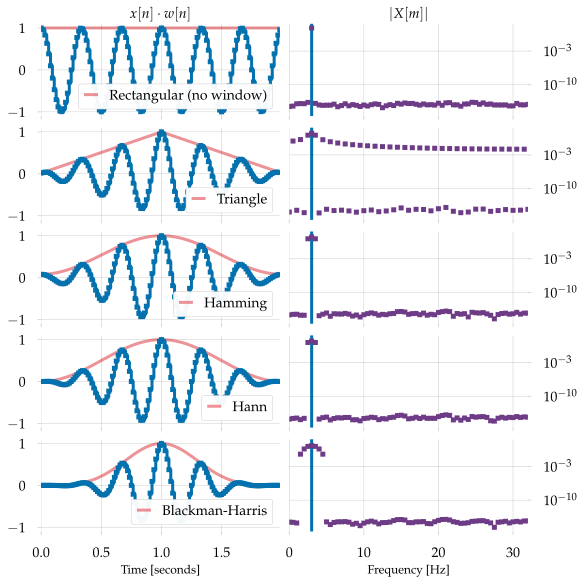

In [16]:
from matplotlib import gridspec

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=figaspect(1), sharey='col', sharex='col')

fs = 64
N = 2 * fs

f0 = 6 * fs / N

t = np.arange(N) / fs
x = np.cos(2 * np.pi * f0 * t)

w0 = scipy.signal.get_window('rect', len(x))
w1 = scipy.signal.get_window('triang', len(x))
w2 = scipy.signal.get_window('hamming', len(x))
w3 = scipy.signal.get_window('hann', len(x))
w4 = scipy.signal.get_window('blackmanharris', len(x))

freqs = np.abs(np.fft.fftfreq(N, 1./fs)[:1 + N//2])

for n in range(len(axes)):
    axes[n, 1].yaxis.tick_right()
    
axes[0, 0].step(t, x * w0,   marker='s', where='post')
axes[0, 0].plot(t, w0, color=colors[1],  alpha=0.5, zorder=-1, label='Rectangular (no window)')
axes[0, 0].legend(loc='lower right')
axes[0, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w0)), linestyle='', marker='s', color=colors[4])
axes[0, 1].axvline(f0, zorder=-1, color=colors[0])
axes[0, 0].label_outer()
#axes[0, 1].label_outer()

axes[1, 0].step(t, x * w1, marker='s',  where='post')
axes[1, 0].plot(t, w1, color=colors[1], alpha=0.5, zorder=-1, label='Triangle')
axes[1, 0].legend(loc='lower right')
axes[1, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w1)), linestyle='', marker='s',  color=colors[4])
axes[1, 1].axvline(f0, zorder=-1,  color=colors[0])
axes[1, 0].label_outer()
#axes[1, 1].label_outer()

axes[2, 0].step(t, x * w2,  marker='s', where='post')
axes[2, 0].plot(t, w2, color=colors[1],  alpha=0.5, zorder=-1, label='Hamming')
axes[2, 0].legend(loc='lower right')
axes[2, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w2)), linestyle='', marker='s',  color=colors[4])
axes[2, 1].axvline(f0, zorder=-1, color=colors[0])
axes[2, 0].label_outer()
#axes[2, 1].label_outer()

axes[3, 0].step(t, x * w3, marker='s',  where='post')
axes[3, 0].plot(t, w3, color=colors[1], alpha=0.5, zorder=-1, label='Hann')
axes[3, 0].legend(loc='lower right')
axes[3, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w3)), linestyle='', marker='s', color=colors[4])
axes[3, 1].axvline(f0, zorder=-1,  color=colors[0])
axes[3, 0].label_outer()
#axes[3, 1].label_outer()

axes[4, 0].step(t, x * w4,  marker='s',  where='post')
axes[4, 0].plot(t, w4, color=colors[1],  alpha=0.5, zorder=-1, label='Blackman-Harris')
axes[4, 0].legend(loc='lower right')
axes[4, 1].semilogy(freqs, np.abs(np.fft.rfft(x * w4)), linestyle='', marker='s',  color=colors[4])
axes[4, 1].axvline(f0, zorder=-1, color=colors[0])
axes[4, 0].label_outer()
#axes[4, 1].label_outer()

axes[4, 0].set(xlabel='Time [seconds]')
axes[4, 1].set(xlabel='Frequency [Hz]')

axes[0, 0].set(title=r'$x[n] \cdot w[n]$')
axes[0, 1].set(title=r'$|X[m]|$')
#axes[4, 1].set(ylim=[1e-6, 1e3])
glue('window-analysis-examples', fig, display=False)

```{glue:figure} window-analysis-examples
---
name: window-analysis-examples
---
Different choices of window function $w$ and the corresponding DFT magnitude spectrum after applying each window to a sinusoid at **analysis** frequency $f=3$ Hz.
```

The spectral plots in {numref}`window-analysis-examples` illustrate another price that we must pay to counteract leakage: if we do have analysis frequencies in the signal, applying windowing will spread some of their energy across the spectrum.
Although in all cases, the energy far from the fundamental frequency ($f=3$) is very small (numerically close to 0), the energy in the windowed signals is dispersed around the peak, rather than being concentrated like in the un-windowed case.

One way to view this trade-off is that windowing reduces the distinction between analysis and non-analysis frequencies: both end up leaking across the spectrum, but the choice of window function allows us to control this behavior.
In reality, almost no naturally occurring signals will line up precisely to the parameters of your signal analysis, so it's safer to assume that all energy is coming from non-analysis frequencies anyway.

## Windowing in practice

Most signal processing frameworks provide a library of pre-defined window functions.
In Python, these are provided by the function ``scipy.signal.get_window``.
To use a windowing function as we did in the example above, one first constructs the window of a given length, and then applies the DFT:

```python
# We'll assume the input signal x already exists, and get its length
N = len(x)

# Build the window
w = scipy.signal.get_window('hann', N)

# Multiply by w and take the DFT
X = np.fft.rfft(x * w)
```

## Summary

In this section, we've seen that windowing can help reduce the bad effects of spectral leakage.
This doesn't necessarily mean that windowing should always be used, however, as it does alter the content of the signal.

As we will see later on, the main application of windowing has to do with the *short-time Fourier transform*, where a long signal is carved into small pieces for analysis purposes.